Goal is to attribute transformer output to either earlier positions or lower layers

First apply the full model forward from Token through to LM Head without attribution

In [1]:
from transformer_utils.low_memory import enable_low_memory_load
import transformers

enable_low_memory_load()
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125M')

c:\users\stephenprior\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
from src.visualization import visualize

In [3]:
text = "The forecast said that thunderstorm activity with the risk of hail will lead to localised"
tokens = visualize.text_to_input_ids(tokenizer, text)
tokens

tensor([[  464, 11092,   531,   326, 18355, 12135,  3842,   351,   262,  2526,
           286, 32405,   481,  1085,   284,  1957,  1417]], device='cuda:0')

In [4]:
tokenizer.batch_decode(tokens),tokenizer.decode(1417)

(['The forecast said that thunderstorm activity with the risk of hail will lead to localised'],
 'ised')

In [5]:
model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=0, out_features=768, bias=False)
            (v_proj): Linear(in_features=0, out_features=768, bias=False)
            (q_proj): Linear(in_features=0, out_features=768, bias=False)
            (out_proj): Linear(in_features=0, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=0, out_features=3072, bias=True)
          (c_proj): Linear(in_features=0, out_features=7

In [6]:
expected_token_id = 17448
tokenizer.decode(expected_token_id)

' flooding'

Apply the Captum Integrated Gradients algorithm to attribute this token to previous input tokens.
We cannot use the LMHead model because it is not straightforward to apply attribution to the embedding step

In [27]:
from captum.attr import IntegratedGradients

embeds = model.transformer.wte(tokens)

def forward_with_embeds(embeds):
    transformer_outputs = model.transformer.forward(inputs_embeds=embeds)
    hidden_states = transformer_outputs[0]
    lm_logits = model.lm_head(hidden_states)
    return lm_logits[0,-1,expected_token_id:expected_token_id+1]

ig=IntegratedGradients(forward_with_embeds)
embeds.requires_grad_()
attr, delta = ig.attribute(embeds,return_convergence_delta=True)#, target=expected_token_id)
attr = attr.detach().cpu().numpy()

In [32]:
attr[0].shape

(17, 768)

In [31]:
attr[0].shap

array([[[-3.29796156e-03, -1.07006942e-02,  4.07403522e-04, ...,
         -1.90527024e-02, -8.24011307e-04,  2.28353885e-02],
        [-3.05331149e-01,  6.00705810e-01, -1.25631762e-01, ...,
          1.45981987e-01,  1.37261276e-02, -1.18523501e-01],
        [-9.16667706e-02, -3.14197896e-01,  3.57470340e-02, ...,
         -9.64195247e-02,  3.47905966e-02,  1.82564405e-02],
        ...,
        [-4.30027424e-03,  7.47382428e-02, -4.02639004e-03, ...,
         -1.18789637e-02, -4.61651862e-03,  9.14618413e-02],
        [ 4.85033092e-02, -5.49573705e-01,  8.13870024e-02, ...,
          2.20733374e-02,  9.25453030e-02, -4.63039483e-02],
        [-2.75263210e-01,  2.78068634e-01, -7.51757880e-02, ...,
          4.19247301e-02, -4.03581138e-01,  1.02674012e-01]]])

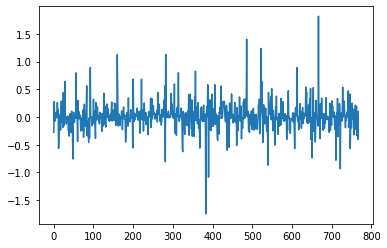

In [36]:
import matplotlib.pyplot as plt
plt.plot(attr[0,16])


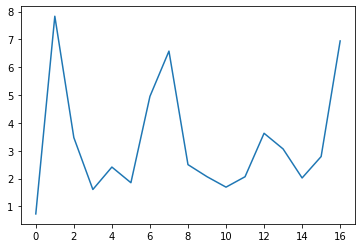

In [38]:
import numpy as np
def norm(vector):
    return np.linalg.norm(vector)
norms = list(map(norm,attr[0]))
plt.plot(norms)
